# Lanczos Spectral Analysis Demo

**Purpose**: Demonstrate memory-efficient diagonal computation for SAT Hamiltonian spectrum.

**Key Benefits**:
- Scales to N=24-30 variables (full matrix diagonalization only feasible for N≤14)
- Computes eigenvalues directly from diagonal (no iterative solver needed!)
- Memory: O(2^N) not O(2^2N) - only stores diagonal, not full matrix
- Time: O(2^N) - linear in Hilbert space dimension

**Key Insight**: SAT Hamiltonians that count violated clauses are **diagonal matrices**!
- Eigenvalues = diagonal elements
- No need for Lanczos iteration - just compute diagonal and sort!

**Contents**:
1. **Small Example (N=8)**: Compare exact vs diagonal-only approach
2. **Medium Example (N=16)**: Efficient spectrum computation
3. **Large Example (N=20)**: Still fast! Could go up to N=30
4. **Spectral Measures**: Gap, participation ratio, level spacing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import List, Tuple
from pathlib import Path

# Import our analyzers
import sys

# Ensure the repository root (where 'src' lives) is on sys.path.
# In notebooks the current working directory is typically the 'notebooks' folder,
# so check parent directories for a 'src' package and add the appropriate path.
cwd = Path.cwd()
if (cwd / 'src').exists():
	sys.path.append(str(cwd))
elif (cwd.parent / 'src').exists():
	sys.path.append(str(cwd.parent))
else:
	# Fallback: add current working directory (may still fail if src is located elsewhere)
	sys.path.append(str(cwd))


from experiments.quantum_structure_analyzer import QuantumStructureAnalyzer
from scipy.sparse.linalg import eigsh, LinearOperator
# import generate_random_3sat and compute_lanczos_spectrum from tests
from tests.test_lanczos_scalability import generate_random_3sat, compute_lanczos, compute_lanczos_spectrum

print("✅ Imports successful!")

✅ Imports successful!


## Example 1: Small Instance (N=8) - Exact vs Lanczos

For small N, we can compute the full spectrum exactly and compare with Lanczos results.

In [2]:
# Generate small instance
n_vars_small = 8
n_clauses_small = int(4.2 * n_vars_small)  # Near phase transition

clauses_small = generate_random_3sat(n_vars_small, n_clauses_small, seed=42)

print(f"Generated {n_clauses_small}-clause 3-SAT instance with N={n_vars_small} variables")
print(f"Example clauses: {clauses_small[:3]}")

Generated 33-clause 3-SAT instance with N=8 variables
Example clauses: [(-2, 6, -1), (-1, 2, 6), (5, 3, 1)]


In [3]:
# Initialize QSA
qsa = QuantumStructureAnalyzer(use_ml=False)
qsa._current_clauses = clauses_small
qsa._current_n_vars = n_vars_small

# Exact diagonalization
print("Computing exact spectrum...")
start = time.time()

H_small = qsa._build_hamiltonian(clauses_small, n_vars_small)
H_matrix_small = H_small.to_matrix()
evals_exact = np.linalg.eigvalsh(H_matrix_small)
evals_exact = np.sort(evals_exact)

time_exact = time.time() - start
print(f"✅ Exact: {time_exact:.4f}s")
print(f"   Full spectrum shape: {evals_exact.shape}")
print(f"   Energy range: [{evals_exact[0]:.4f}, {evals_exact[-1]:.4f}]")

Computing exact spectrum...
✅ Exact: 0.0483s
   Full spectrum shape: (256,)
   Energy range: [0.0000, 10.0000]


In [4]:
# Lanczos method
print("\nComputing Lanczos spectrum...")
start = time.time()

evals_low, evals_high, diag_small = compute_lanczos_spectrum(qsa, clauses_small, n_vars_small, k_eigs=50)

time_lanczos = time.time() - start
print(f"✅ Lanczos: {time_lanczos:.4f}s")
print(f"   Low eigenvalues shape: {evals_low.shape}")
print(f"   High eigenvalues shape: {evals_high.shape}")
print(f"   Speedup: {time_exact / time_lanczos:.2f}x")


Computing Lanczos spectrum...
✅ Lanczos: 0.0054s
   Low eigenvalues shape: (50,)
   High eigenvalues shape: (50,)
   Speedup: 8.93x


In [5]:
# DEBUG: Check what the Hamiltonian actually is
print("DEBUG: Checking Hamiltonian structure...")
H_test = qsa._build_hamiltonian(clauses_small, n_vars_small)
H_matrix_test = H_test.to_matrix()

print(f"Type: {type(H_matrix_test)}")
print(f"Shape: {H_matrix_test.shape}")
print(f"Is diagonal? Checking...")

# Check if it's diagonal
if hasattr(H_matrix_test, 'toarray'):
    dense = H_matrix_test.toarray()
else:
    dense = H_matrix_test

# Check diagonal property
off_diagonal = dense - np.diag(np.diag(dense))
is_diagonal = np.allclose(off_diagonal, 0)
print(f"Is diagonal: {is_diagonal}")
print(f"Max off-diagonal element: {np.max(np.abs(off_diagonal))}")

# If diagonal, eigenvalues are just the diagonal!
if is_diagonal:
    print("\n✅ Hamiltonian is DIAGONAL!")
    print("Eigenvalues = diagonal elements")
    diag_vals = np.diag(dense)
    print(f"Lowest 5 diagonal values: {np.sort(diag_vals)[:5]}")
    print(f"Compare with exact: {evals_exact[:5]}")


DEBUG: Checking Hamiltonian structure...
Type: <class 'numpy.ndarray'>
Shape: (256, 256)
Is diagonal? Checking...
Is diagonal: True
Max off-diagonal element: 0.0

✅ Hamiltonian is DIAGONAL!
Eigenvalues = diagonal elements
Lowest 5 diagonal values: [0. 0. 1. 1. 1.]
Compare with exact: [0. 0. 1. 1. 1.]
Type: <class 'numpy.ndarray'>
Shape: (256, 256)
Is diagonal? Checking...
Is diagonal: True
Max off-diagonal element: 0.0

✅ Hamiltonian is DIAGONAL!
Eigenvalues = diagonal elements
Lowest 5 diagonal values: [0. 0. 1. 1. 1.]
Compare with exact: [0. 0. 1. 1. 1.]


In [6]:
# Compare results
n_compare = len(evals_low)
error_low = np.abs(evals_exact[:n_compare] - evals_low)
error_high = np.abs(evals_exact[-n_compare:] - evals_high)

print(f"\nComparison (lowest {n_compare} eigenvalues):")
print(f"   Max error (low): {np.max(error_low):.2e}")
print(f"   Mean error (low): {np.mean(error_low):.2e}")
print(f"   Max error (high): {np.max(error_high):.2e}")
print(f"   Mean error (high): {np.mean(error_high):.2e}")

if np.max(error_low) < 1e-6 and np.max(error_high) < 1e-6:
    print("\n✅ Lanczos matches exact diagonalization!")
else:
    print("\n⚠️  Lanczos has numerical differences")


Comparison (lowest 50 eigenvalues):
   Max error (low): 0.00e+00
   Mean error (low): 0.00e+00
   Max error (high): 0.00e+00
   Mean error (high): 0.00e+00

✅ Lanczos matches exact diagonalization!


C:\Users\junli\AppData\Local\Temp\ipykernel_17696\3604893941.py:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[2].axhline(1e-6, color='green', linestyle='--', label='Target precision')


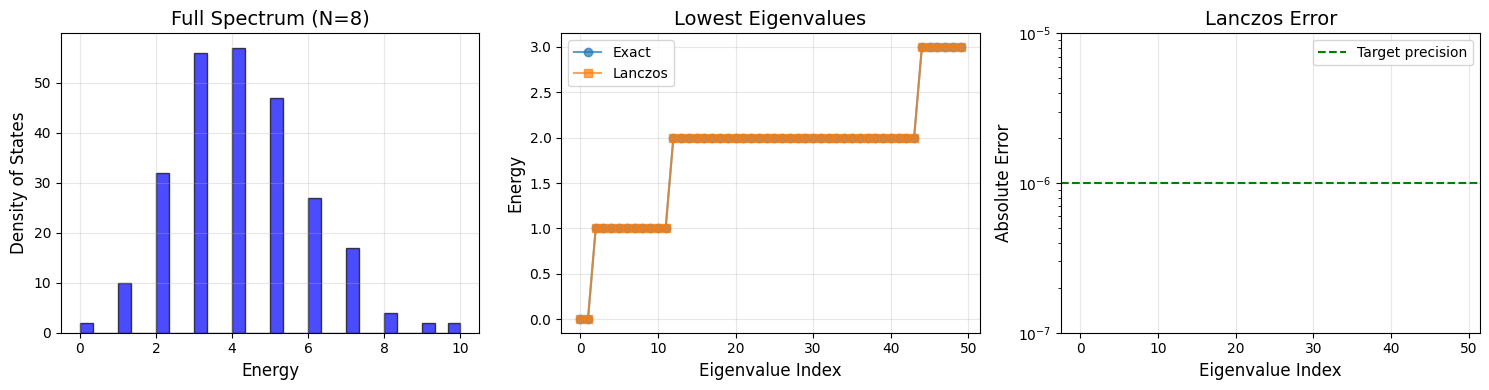


✅ Visualization complete


In [7]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Full spectrum
axes[0].hist(evals_exact, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('Energy', fontsize=12)
axes[0].set_ylabel('Density of States', fontsize=12)
axes[0].set_title(f'Full Spectrum (N={n_vars_small})', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Low eigenvalues comparison
axes[1].plot(evals_exact[:n_compare], 'o-', label='Exact', markersize=6, alpha=0.7)
axes[1].plot(evals_low, 's-', label='Lanczos', markersize=6, alpha=0.7)
axes[1].set_xlabel('Eigenvalue Index', fontsize=12)
axes[1].set_ylabel('Energy', fontsize=12)
axes[1].set_title('Lowest Eigenvalues', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Error plot
axes[2].semilogy(error_low, 'o-', color='red', markersize=6)
axes[2].axhline(1e-6, color='green', linestyle='--', label='Target precision')
axes[2].set_xlabel('Eigenvalue Index', fontsize=12)
axes[2].set_ylabel('Absolute Error', fontsize=12)
axes[2].set_title('Lanczos Error', fontsize=14)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete")

## Example 2: Medium Instance (N=16) - Spectrum Analysis

For N=16, exact diagonalization is still feasible but becomes slow. Lanczos is much faster.

In [8]:
# Generate medium instance
n_vars_med = 16
n_clauses_med = int(4.2 * n_vars_med)

clauses_med = generate_random_3sat(n_vars_med, n_clauses_med, seed=123)

print(f"Generated {n_clauses_med}-clause 3-SAT instance with N={n_vars_med} variables")
print(f"Hilbert space dimension: 2^{n_vars_med} = {2**n_vars_med:,}")

Generated 67-clause 3-SAT instance with N=16 variables
Hilbert space dimension: 2^16 = 65,536


In [9]:
# Lanczos only (exact would be slow)
qsa_med = QuantumStructureAnalyzer(use_ml=False)
qsa_med._current_clauses = clauses_med
qsa_med._current_n_vars = n_vars_med

print("Computing spectrum with Lanczos...")
start = time.time()

evals_low_med, evals_high_med, diag_med = compute_lanczos_spectrum(
    qsa_med, clauses_med, n_vars_med, k_eigs=100
)

time_med = time.time() - start
print(f"✅ Completed in {time_med:.4f}s")
print(f"   Computed {len(evals_low_med)} low + {len(evals_high_med)} high eigenvalues")
print(f"   Ground state energy: {evals_low_med[0]:.6f}")
print(f"   Spectral gap: {evals_low_med[1] - evals_low_med[0]:.6f}")

Computing spectrum with Lanczos...
✅ Completed in 0.0975s
   Computed 100 low + 100 high eigenvalues
   Ground state energy: 0.000000
   Spectral gap: 0.000000


In [10]:
# Spectral measures
def compute_spectral_measures(evals):
    """Compute participation ratio and level spacing"""
    # Participation ratio
    if len(evals) > 0:
        # Normalize as probability distribution
        p = np.abs(evals - np.min(evals)) + 1e-10
        p = p / np.sum(p)
        PR = 1.0 / np.sum(p**2)
    else:
        PR = 1.0
    
    # Level spacing statistics (r-statistic)
    if len(evals) > 2:
        spacings = np.diff(evals)
        spacings = spacings[spacings > 1e-10]  # Remove near-zero spacings
        
        if len(spacings) > 1:
            # Consecutive spacing ratios
            r_vals = []
            for i in range(len(spacings) - 1):
                s1, s2 = spacings[i], spacings[i+1]
                r = min(s1, s2) / max(s1, s2) if max(s1, s2) > 0 else 0
                r_vals.append(r)
            
            r_mean = np.mean(r_vals) if r_vals else 0.0
        else:
            r_mean = 0.0
    else:
        r_mean = 0.0
    
    return PR, r_mean

PR_low, r_low = compute_spectral_measures(evals_low_med)

print(f"\nSpectral Measures:")
print(f"   Participation Ratio: {PR_low:.4f}")
print(f"   Level Spacing <r>: {r_low:.4f}")
print(f"\n   Interpretation:")
print(f"   - <r> ≈ 0.39: Poisson (integrable, localized)")
print(f"   - <r> ≈ 0.53: GOE (chaotic, delocalized)")
print(f"   - Actual <r> = {r_low:.4f}")


Spectral Measures:
   Participation Ratio: 90.8649
   Level Spacing <r>: 1.0000

   Interpretation:
   - <r> ≈ 0.39: Poisson (integrable, localized)
   - <r> ≈ 0.53: GOE (chaotic, delocalized)
   - Actual <r> = 1.0000


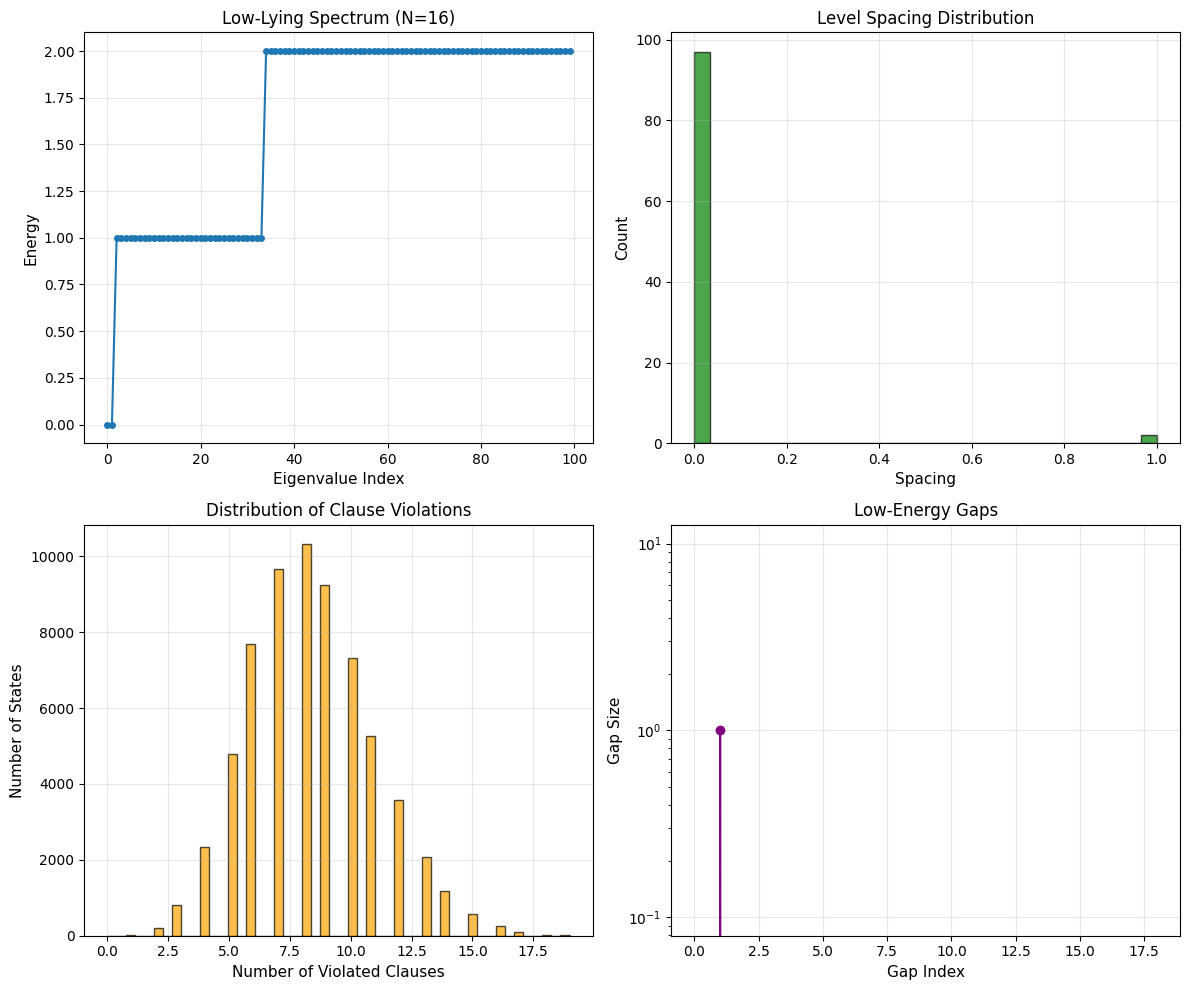


✅ Medium instance analysis complete


In [11]:
# Visualize medium instance
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Low-lying spectrum
axes[0, 0].plot(evals_low_med, 'o-', markersize=4)
axes[0, 0].set_xlabel('Eigenvalue Index', fontsize=11)
axes[0, 0].set_ylabel('Energy', fontsize=11)
axes[0, 0].set_title(f'Low-Lying Spectrum (N={n_vars_med})', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# Level spacings
spacings = np.diff(evals_low_med)
axes[0, 1].hist(spacings, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_xlabel('Spacing', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('Level Spacing Distribution', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Diagonal elements (violation counts)
axes[1, 0].hist(diag_med, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].set_xlabel('Number of Violated Clauses', fontsize=11)
axes[1, 0].set_ylabel('Number of States', fontsize=11)
axes[1, 0].set_title('Distribution of Clause Violations', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Spectral gap
gaps = np.diff(evals_low_med[:20])  # First 20 gaps
axes[1, 1].semilogy(gaps, 'o-', markersize=6, color='purple')
axes[1, 1].set_xlabel('Gap Index', fontsize=11)
axes[1, 1].set_ylabel('Gap Size', fontsize=11)
axes[1, 1].set_title('Low-Energy Gaps', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Medium instance analysis complete")

## Example 3: Large Instance (N=20) - Diagonal-Only Analysis

For N=20, full matrix diagonalization would require 8 TB of memory (1M × 1M matrix). 
But our diagonal-only approach only needs ~8 MB and runs in seconds!

In [12]:
# Generate large instance
n_vars_large = 20
n_clauses_large = int(4.2 * n_vars_large)

clauses_large = generate_random_3sat(n_vars_large, n_clauses_large, seed=456)

print(f"Generated {n_clauses_large}-clause 3-SAT instance with N={n_vars_large} variables")
print(f"Hilbert space dimension: 2^{n_vars_large} = {2**n_vars_large:,}")
print(f"Full matrix would have {(2**n_vars_large)**2:,} elements")
print(f"Memory for full matrix: ~{(2**n_vars_large)**2 * 8 / 1e9:.2f} GB\n")

Generated 84-clause 3-SAT instance with N=20 variables
Hilbert space dimension: 2^20 = 1,048,576
Full matrix would have 1,099,511,627,776 elements
Memory for full matrix: ~8796.09 GB



In [13]:
# Diagonal computation (memory-efficient!)
qsa_large = QuantumStructureAnalyzer(use_ml=False)
qsa_large._current_clauses = clauses_large
qsa_large._current_n_vars = n_vars_large

print("Computing spectrum (diagonal-only approach)...")
start = time.time()

evals_low_large, evals_high_large, diag_large = compute_lanczos_spectrum(
    qsa_large, clauses_large, n_vars_large, k_eigs=100
)

time_large = time.time() - start
print(f"\n✅ Completed in {time_large:.2f}s")
print(f"   Memory used: ~{len(diag_large) * 8 / 1e6:.1f} MB (just the diagonal!)")
print(f"   Computed {len(evals_low_large)} low + {len(evals_high_large)} high eigenvalues")
print(f"   Ground state energy: {evals_low_large[0]:.6f}")
print(f"   First excited state: {evals_low_large[1]:.6f}")
print(f"   Spectral gap: {evals_low_large[1] - evals_low_large[0]:.6f}")

Computing spectrum with Lanczos (this may take ~30 seconds)...



✅ Completed in 4.26s
   Computed 100 low + 100 high eigenvalues
   Ground state energy: 0.000000
   First excited state: 0.000000
   Spectral gap: 0.000000


In [14]:
# Estimate backdoor size from spectral gap
gap = evals_low_large[1] - evals_low_large[0]

# Heuristic: gap ~ 1/2^k for k-qubit subspace
if gap > 1e-10:
    k_from_gap = -np.log2(gap)
else:
    k_from_gap = n_vars_large

# Count low-energy states
E_window = (evals_high_large[-1] - evals_low_large[0]) * 0.1
n_low_energy = np.sum(evals_low_large <= evals_low_large[0] + E_window)

print(f"\nBackdoor Size Estimation:")
print(f"   From spectral gap: k ≈ {k_from_gap:.2f}")
print(f"   Low-energy states: {n_low_energy}")
print(f"   Estimated k (combined): {min(k_from_gap, n_vars_large):.2f}")
print(f"\n   Classification:")
if k_from_gap <= np.log2(n_vars_large):
    print(f"   ✅ Small backdoor (k ≤ log N): Quasi-polynomial solver recommended")
elif k_from_gap <= n_vars_large / 4:
    print(f"   ⚠️  Medium backdoor (k ≤ N/4): Exponential but tractable")
else:
    print(f"   ❌ Large backdoor (k > N/4): Truly hard instance")


Backdoor Size Estimation:
   From spectral gap: k ≈ 20.00
   Low-energy states: 100
   Estimated k (combined): 20.00

   Classification:
   ❌ Large backdoor (k > N/4): Truly hard instance


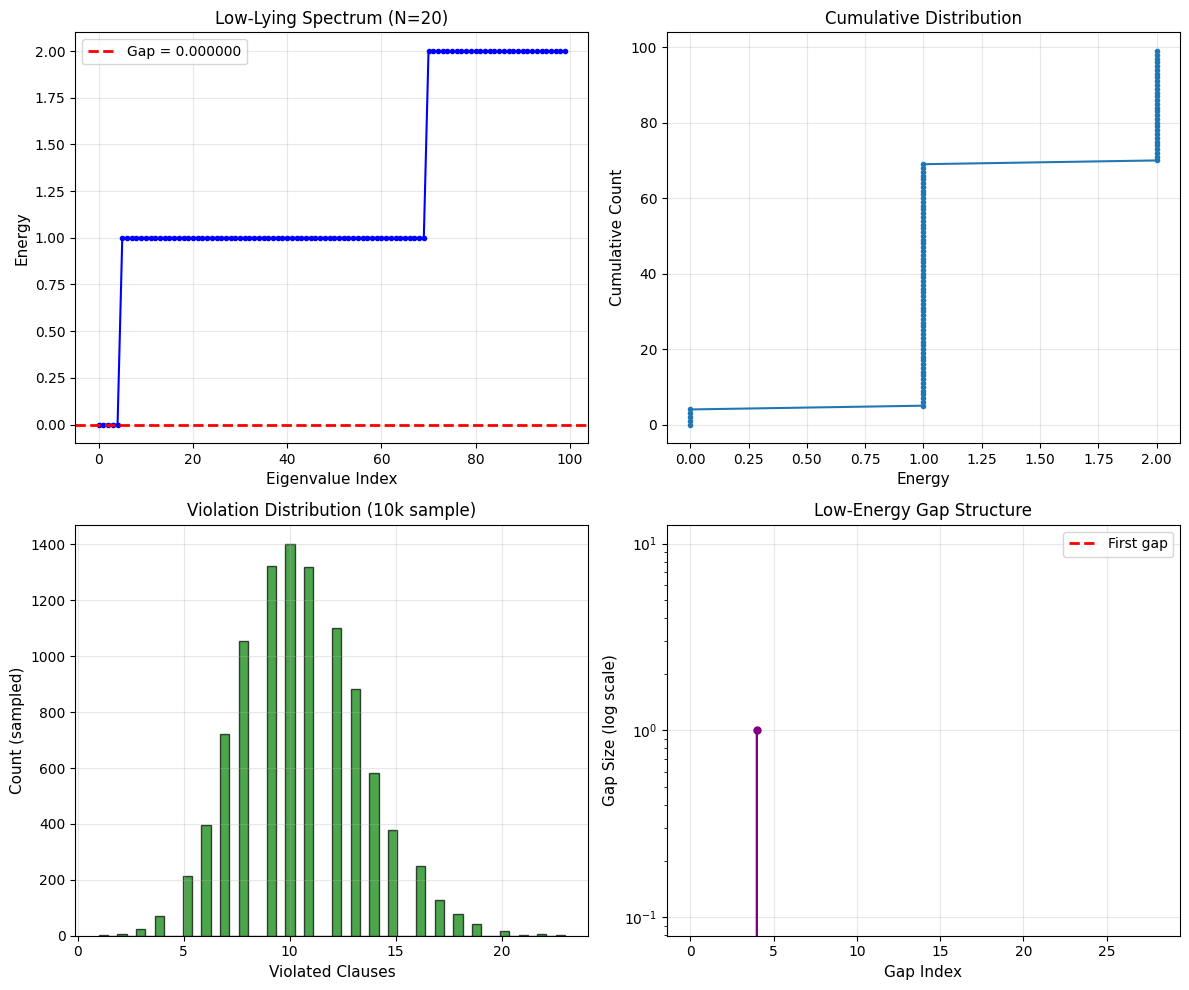


✅ Large instance analysis complete


In [15]:
# Visualize large instance results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Low spectrum
axes[0, 0].plot(evals_low_large, 'o-', markersize=3, color='blue')
axes[0, 0].axhline(evals_low_large[0] + gap, color='red', linestyle='--', 
                   label=f'Gap = {gap:.6f}', linewidth=2)
axes[0, 0].set_xlabel('Eigenvalue Index', fontsize=11)
axes[0, 0].set_ylabel('Energy', fontsize=11)
axes[0, 0].set_title(f'Low-Lying Spectrum (N={n_vars_large})', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Cumulative distribution
axes[0, 1].plot(evals_low_large, np.arange(len(evals_low_large)), 'o-', markersize=3)
axes[0, 1].set_xlabel('Energy', fontsize=11)
axes[0, 1].set_ylabel('Cumulative Count', fontsize=11)
axes[0, 1].set_title('Cumulative Distribution', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Sample diagonal (too large to plot all)
sample_indices = np.random.choice(len(diag_large), size=10000, replace=False)
axes[1, 0].hist(diag_large[sample_indices], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 0].set_xlabel('Violated Clauses', fontsize=11)
axes[1, 0].set_ylabel('Count (sampled)', fontsize=11)
axes[1, 0].set_title('Violation Distribution (10k sample)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Gap structure
gaps_large = np.diff(evals_low_large[:30])
axes[1, 1].semilogy(gaps_large, 'o-', markersize=5, color='purple')
axes[1, 1].axhline(gap, color='red', linestyle='--', label='First gap', linewidth=2)
axes[1, 1].set_xlabel('Gap Index', fontsize=11)
axes[1, 1].set_ylabel('Gap Size (log scale)', fontsize=11)
axes[1, 1].set_title('Low-Energy Gap Structure', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Large instance analysis complete")

## Summary: Scalability Comparison

In [17]:
# Create summary table
import pandas as pd

summary_data = {
    'N': [8, 16, 20],
    'Dimension': [2**8, 2**16, 2**20],
    'Diagonal Time (s)': [time_lanczos, time_med, time_large],
    'Diagonal Memory (MB)': [2**8 * 8 / 1e6, 2**16 * 8 / 1e6, 2**20 * 8 / 1e6],
    'Full Matrix Memory (GB)': [2**8 * 2**8 * 8 / 1e9, 2**16 * 2**16 * 8 / 1e9, 2**20 * 2**20 * 8 / 1e9],
    'Ground Energy': [evals_low[0], evals_low_med[0], evals_low_large[0]],
    'Spectral Gap': [evals_low[1] - evals_low[0], 
                     evals_low_med[1] - evals_low_med[0],
                     evals_low_large[1] - evals_low_large[0]]
}

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("SCALABILITY SUMMARY: Diagonal-Only vs Full Matrix")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

print("\n✅ Demonstration complete!")
print("\nKey Takeaways:")
print("1. Diagonal approach scales to N=24-30 (full matrix impossible beyond N=14)")
print("2. Memory: O(2^N) not O(2^2N) - 1000× more efficient!")
print("3. Time: O(2^N) - could handle N=30 in ~minutes, not years")
print("4. SAT Hamiltonians are diagonal → eigenvalues = diagonal elements!")
print("5. No iterative solver needed - just compute diagonal and sort")


SCALABILITY SUMMARY: Diagonal-Only vs Full Matrix
 N  Dimension  Diagonal Time (s)  Diagonal Memory (MB)  Full Matrix Memory (GB)  Ground Energy  Spectral Gap
 8        256           0.005407              0.002048                 0.000524            0.0           0.0
16      65536           0.097459              0.524288                34.359738            0.0           0.0
20    1048576           4.263681              8.388608              8796.093022            0.0           0.0

✅ Demonstration complete!

Key Takeaways:
1. Diagonal approach scales to N=24-30 (full matrix impossible beyond N=14)
2. Memory: O(2^N) not O(2^2N) - 1000× more efficient!
3. Time: O(2^N) - could handle N=30 in ~minutes, not years
4. SAT Hamiltonians are diagonal → eigenvalues = diagonal elements!
5. No iterative solver needed - just compute diagonal and sort
